## 4.1 누락된 데이터 다루기

### 4.1.1 테이블 형태 데이터에서 누락된 값 식별

In [2]:
import pandas as pd
from io import StringIO

csv_data = \
"""A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0, 11.0, 12.0,
"""
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
# null값 확인
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

### 4.1.2 누락된 값이 있는 훈련 샘플이나 특성 제외

In [4]:
df.dropna(axis=0) # axis=0 은 행 삭제, axis=1은 열 삭제

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [5]:
# 모든 열이 NaN일 때만 행을 삭제
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# NaN이 아닌 값이 4개보다 작은 행을 삭제
df.dropna(thresh=4) 

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# 특정 열에 NaN이 있는 행만 삭제
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### 4.1.3 누락된 값 대체 
- 보간(interpolation) 기법

In [8]:
# 평균으로 대체하는 보간 기법
# 각 특성 열의 평균으로 누락된 값 대체  

# simpleimputer 클래스는 한 특성의 통계 값을 사용하여 누락된 값을 채운다.

from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

위의 결과에서 1,2,4번째 열의 수치 총합 -> 1+5+2+6+4+8 = 24

각 열의 평균 24 / 4 = 6

-> 3번째 열의 누락값 3으로 대체

In [9]:
from sklearn.preprocessing import FunctionTransformer
ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T, validate=False)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

In [10]:
imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

# 누락된 값의 위치 인덱스가 왜 1. , 0. 혹은 0. , 1. 으로 표현되는지? -> 대략 알 것 같음

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

In [11]:
imr.indicator_.features_

array([2, 3])

In [12]:
# 누락된 값의 위치를 나타내는 배열을 반환 -> 이 배열 값이 imr의 transform 메서드가 반환한 배열의 마지막 두 열에 해당함

imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [13]:
# 누락된 값을 대체한 배열을 원본 배열의 값으로 복원

imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [14]:
# IterativeImputer 클래스는 누락된 값이 있는 특성과 다른 특성을 사용하여 누락된 값을 예측한다. 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iimr = IterativeImputer()
iimr.fit_transform(df.values)

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.00047063,  8.        ],
       [10.        , 11.        , 12.        , 12.99964527]])

In [15]:
# KNNImputer 클래스는 k-최근접 이웃 방식을 사용하여 누락된 값을 채운다.
# 샘플 개수가 n_neighbors보다 작으면 simpleimputer (strategy='mean') 과 결과가 같다.

from sklearn.impute import KNNImputer
kimr = KNNImputer()
kimr.fit_transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [16]:
# 판다스의 fillna 메서드로 누락된 값 채우기

df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [17]:
df.fillna(method='backfill') # 누락값을 다음 행의 값으로 채운다.

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [18]:
df.fillna(method='ffill')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


In [19]:
df.fillna(method='ffill', axis=1) # 누락값을 이전 열의 값으로 채운다.

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0


## 4.2 범주형 데이터 다루기

범주형 데이터 
1. 순서가 있는 범주형 데이터 ex. 티셔츠의 사이즈 (XL > L)
2. 순서가 없는 범주형 데이터 ex. 색깔

In [39]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 4.2.2 순서가 있는 특성 매핑

In [40]:
# size feature의 산술적인 관계를 XL = L + 1 = M + 2 라고 가정

size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [41]:
size_mapping.items()

dict_items([('XL', 3), ('L', 2), ('M', 1)])

In [42]:
# 원래의 레이블로 복원

inv_size_mapping = {v: k  for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 4.2.3 클래스 레이블 인코딩

In [52]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [53]:
import numpy as np
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [54]:
df['classlabel'] = df['classlabel'].map(class_mapping) # map함수가 class_mapping의 키값을 찾아서 value값으로 바꾼다.
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [55]:
inv_class_mapping = {v : k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [47]:
# LabelEncoder 클래스로 문자열 레이블을 정수 레이블로 인코딩

from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [48]:
# 원본 문자열로 복원 

class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

In [50]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0]) # LabelEncoder는 입력 데이터로 1차원 배열을 받는다.
X

# blue = 0, green = 1, red = 2

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [56]:
# 여러 개의 열을 한번에 정수로 변환

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

/var/folders/0t/m5tmk07x1jn8mbwk5mpr748h0000gp/T/ipykernel_58194/197280886.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ord_enc = OrdinalEncoder(dtype=np.int)


array([[1],
       [2],
       [0]])

In [57]:
# 정수로 인코딩된 값을 다시 문자열로 복원

col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

In [58]:
# one-hot-encoding

from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [59]:
# columntransformer를 사용하여 color 특성(열)에만 원핫인코딩 적용

from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [61]:
# pandas의 get_dummies 메서드를 사용하여 범주형 feature 원핫인코딩
# 범주형 

pd.get_dummies(df[['price', 'color', 'size']])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


In [ ]:
# columns 매개변수를 사용하여 변환하려는 feature 명시

pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

In [63]:
# 원핫인코딩한 feature의 첫번째 열(color_blue)을 삭제

pd.get_dummies(df[['price', 'color', 'size']],
              drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


#### 다중 공선성 문제

특성 간의 상관관계가 높으면 역행렬을 계산하기 어려워 수치적으로 불안정해진다. 
- 변수 간의 상관관계를 감소시키려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제한다. 
- 이렇게 특성을 삭제해도 잃는 정보는 없다.
- ex. color_blue열을 삭제해도 color_green=0, color_red=0 일 때, blue임을 알 수 있다. 

In [66]:
# 원핫인코딩 후 생성된 더미 변수들 중 첫번째 더미 변수 (첫번째 열) 삭제

color_ohe = OneHotEncoder(categories='auto')
c_transf = ColumnTransformer([
    ('onehot', color_ohe, [0]), # 0번째 특성에 원핫인코딩 적용
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

#### Note. 순서가 있는 특성 인코딩하기

순서가 있는 특성의 범주 사이에서 수치적 크기에 대해 확신이 없거나, 두 범주 사이의 순서를 정의할 수 없다면 임계 값을 사용하여 0과1로 인코딩 할 수 있다. 

예를 들어, M, L, XL 값을 가진 특성 size를 2개의 새로운 특성 'x > M'과 'x > L'로 나눌 수 있다. 

In [67]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                  ['red', 'L', 13.5, 'class1'],
                  ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [69]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x in ['XL'] else 0)
del df['size'] # size 특성 삭제
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


### 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기

In [72]:
# wine 데이터셋 가져오기
# 13개의 특성을 가진 178개의 와인 샘플

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                    'Malic acid', 'Ash',
                    'Alcalinity of ash', 'Magnesium',
                    'Total phenols', 'Flavanoids',
                    'Nonflavanoid phenols',
                    'Proanthocyanins',
                    'Color intensity', 'Hue',
                    'OD280/OD315 of diluted wines',
                    'Proline']
print('class label', np.unique(df_wine['Class label']))

class label [1 2 3]


In [73]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [74]:
# 훈련 데이터셋과 테스트 데이터셋을 나누기

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
# stratify 매개변수에 클래스 레이블 배열인 y를 전달하면 훈련 데이터와 테스트 데이터에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지된다.

## 4.4 특성 스케일 맞추기

#### 정규화 & 표준화

정규화 : 특성의 스케일을 [0, 1] 범위에 맞춘다.
- min-max scaling의 특별한 경우

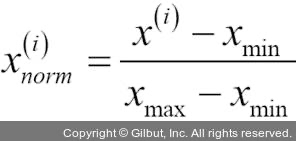

표준화 : 특성의 평균을 0에 맞추고, 표준 편차를 1로 만들어 정규 분포와 같은 특징을 가지도록 만든다.
- 표준화는 이상치 정보가 유지되기 때문에 제한된 범위로 데이터를 조정하는 min-max scaling에 비해 이상치에 덜 민감하다. 

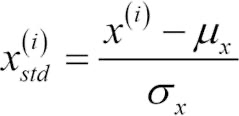

In [75]:
min-max scalin을 사용한 특성의 스케일 조정

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)